In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix, coo_matrix
from functools import partial

from tree_extraction import Aho
from compute_pam import compute_combo_tensor, get_alpha
from sim_data import HPAM2Sampler
from example_graphs import make_tree
from utils import bfs_layout

In [2]:
import sys, os
sys.path.append(os.path.abspath('../anchor-word-recovery/'))

In [3]:
from learn_topics import Analysis, Params

In [4]:
np.random.seed(1)

In [5]:
def nice_tree_plot(t, ax = None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    if t is None:
        return
    draw_kwargs = dict(with_labels=True, pos=bfs_layout(t))
    draw_kwargs.update(kwargs)
    nx.draw(t, **draw_kwargs)

In [6]:
#tree = make_tree([3,3,3])
tree = make_tree([3,3])

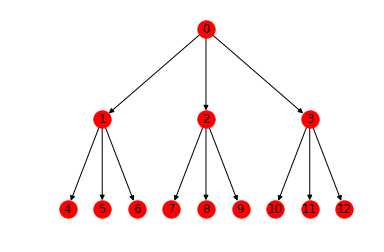

In [7]:
nice_tree_plot(tree)

## Extracting a tree from simulated data

In [8]:
sampler = HPAM2Sampler(
    g = tree,
    num_docs = 5000,
    words_per_doc = 100,
    vocab_size = 1000,
    topic_dirichlet = 0.1)

In [9]:
%%time
sampler.sample();

100%|██████████| 5000/5000 [00:53<00:00, 94.00it/s]

CPU times: user 51.9 s, sys: 1 s, total: 52.9 s
Wall time: 53.2 s


In [10]:
%%time
data = lil_matrix((sampler.num_docs, sampler.vocab_size), dtype='float')
for doc_index, doc in enumerate(tqdm.tqdm(sampler.docs)):
    doc = sorted(doc)
    for vocab_index in doc:
        data[doc_index, vocab_index] += 1
data = csr_matrix(data)

100%|██████████| 5000/5000 [00:04<00:00, 1142.81it/s]

CPU times: user 4.47 s, sys: 87.3 ms, total: 4.55 s
Wall time: 4.55 s


In [11]:
num_digits = len(str(sampler.vocab_size - 1))
vocab = ["w{:0{}d}".format(i, num_digits) for i in range(sampler.vocab_size)]

In [12]:
K = len(tree.nodes())

In [13]:
analysis = Analysis(params = Params(
    infile = data.transpose(),
    vocab_file = vocab,
    outfile = None,
    loss = "L2",
    K = K,
    seed = 100,
    eps = 1e-6,
    new_dim = 1000,
    max_threads = 8,
    anchor_thresh = 100,
    top_words = 10,
))

In [14]:
%%time
analysis.run();

Input matrix shape: (1000, 5000)
identifying candidate anchors
833 candidates
Sum of entries in Q is  1.0000000000000009
Multiplying Q took  0.42403388023376465 seconds
Q sum is 1.0000000000000009
done reading documents
anchors are:
0 w652
1 w458
2 w805
3 w378
4 w943
5 w014
6 w582
7 w539
8 w071
9 w598
10 w021
11 w423
12 w748
begin threaded recovery with 8 processors
0	70	0.28839796155533143
done recovering
w652 : w020 w225 w615 w769 w899 w427 w632 w860 w664 w252 
w458 : w820 w935 w788 w454 w081 w596 w911 w444 w553 w525 
w805 : w498 w899 w646 w732 w053 w060 w768 w209 w120 w351 
w378 : w459 w782 w207 w526 w501 w069 w836 w586 w654 w425 
w943 : w003 w295 w596 w139 w023 w334 w529 w782 w145 w854 
w014 : w966 w710 w986 w369 w380 w900 w622 w223 w082 w734 
w582 : w494 w815 w573 w510 w425 w257 w501 w433 w195 w115 
w539 : w944 w288 w856 w507 w591 w485 w289 w954 w240 w233 
w071 : w834 w204 w446 w992 w163 w484 w092 w403 w467 w946 
w598 : w596 w390 w782 w675 w017 w454 w421 w581 w295 w253 
w021 : w00

In [15]:
analysis.Q.shape

(1000, 1000)

In [16]:
R = analysis.R

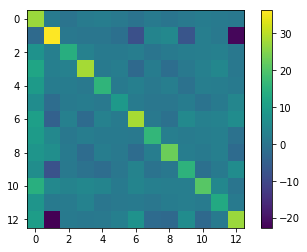

In [17]:
fig, ax = plt.subplots()
ax.imshow(R);
fig.colorbar(ax.get_images()[0]);

In [18]:
np.max(np.abs(R - R.T))

12.442056180574074

In [19]:
R.min(), R.max()

(-22.62576461082845, 36.2590564086482)

In [20]:
R.sum()

547.5506209947425

In [21]:
Rprime = 0.5 * R + 0.5 * R.T
Rprime /= Rprime.sum()
C = Aho.get_ratio_matrix(Rprime)

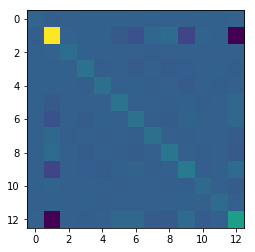

In [22]:
plt.imshow(C);

In [23]:
extracted_tree = Aho.extract(C)

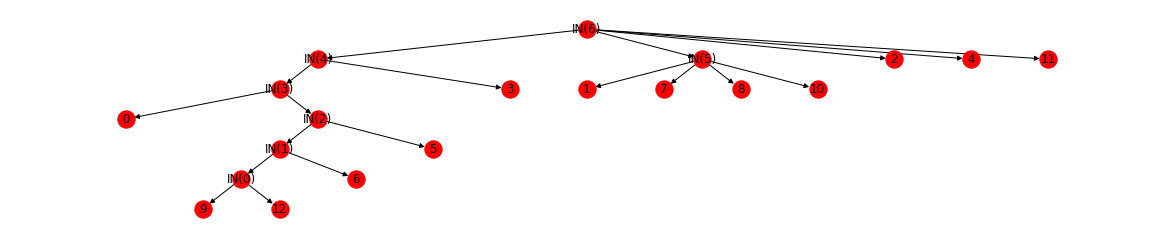

In [24]:
fig, ax = plt.subplots(figsize = (20,4))
nice_tree_plot(extracted_tree, ax=ax)

* TODO: extract tree from real data
* TODO: run the tree-building sequence on the above results

In [25]:
# incorrect topics?  (how to map onto **)
#   - topics with too much overlap?  try sparser dirichlet?
# or: correct topics but noisy R estimation?  (throwing away too many triplets??)